# Experiment - Mutual Information

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])
pysim_root = "/home/emmanuel/code/pysim"
# append to path
sys.path.append(str(root))
sys.path.append(str(pysim_root))

import numpy as np

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
import corner

sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Mutual Information

### Dataset

In [2]:
from pysim.data.information.gaussian import generate_gaussian_mi_data
from pysim.data.information.studentt import generate_studentt_mi_data


from typing import NamedTuple


class MIResult(NamedTuple):
    time: float
    MI: float
    name: str


def get_mi_datasets(n_samples, n_features, seed, dataset="gaussian", **kwargs):

    if dataset == "gaussian":

        res = generate_gaussian_mi_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            n_base_samples=500_000,
        )

    elif dataset == "studentt":

        res = generate_studentt_mi_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            n_base_samples=500_000,
            df=kwargs.get("df", 3.0),
        )

    elif dataset == "cauchy":

        res = generate_studentt_mi_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            n_base_samples=500_000,
            df=1.0,
        )

    else:
        raise ValueError(f"Unrecognized estimator.")

    return res

### Estimators

In [3]:
# !pip install "git+https://github.com/gregversteeg/NPEET.git"
# !pip install mutual-info

In [4]:
from mutual_info.mutual_info import mutual_information as mi_mutual_info
from npeet.entropy_estimators import mi as npeet_mutual_info

In [5]:
from pysim.information.gaussian import gauss_entropy_multi
from pysim.information.knn import knn_entropy, knn_entropy_npeet
from pysim.information.mutual import multivariate_mutual_information
import time


def get_mi_estimators(X, Y, method="gaussian", **kwargs):

    if method == "gaussian":
        t0 = time.time()
        res = multivariate_mutual_information(
            X=X.copy(), Y=Y.copy(), f=gauss_entropy_multi
        )
        t1 = time.time() - t0
        return MIResult(t1, res.MI, "gaussian")

    elif method == "knn_nbs":
        t0 = time.time()
        res = mi_mutual_info((X.copy(), Y.copy()), k=kwargs.get("k", 5), transform=None)
        t1 = time.time() - t0
        return MIResult(t1, res, "knn_nbs")

    elif method == "knn_eps":
        t0 = time.time()
        res = npeet_mutual_info(
            x=X.copy(), y=Y.copy(), base=np.e, k=kwargs.get("k", 5),
        )
        t1 = time.time() - t0
        return MIResult(t1, res, "knn_eps")

    else:
        raise ValueError(f"Unrecognized estimator.")

## Toy Data

In [6]:
from pysim.utils import dict_product

params = {
    "n_samples": [1_000, 2_000, 5_000, 10_000],
    "n_features": [1, 2, 5, 10],
    "n_trials": list(np.arange(1, 21)),
    "dataset": ["gaussian", "studentt", "cauchy"],
}
params = dict_product(params)

### Gaussian

**Implementation Notes**:

1. We randomly generate a positive semi-definite $D \times D$ matrix. This acts as our covariance matrix $\boldsymbol{\Sigma}$.

2. We use a mean, $\boldsymbol{\mu}$ of $\mathbf{0}$.

3. We generate an upper limit of 5e5 data points and then random subset the requested number.

In [7]:
from functools import partial

In [8]:
import tqdm
import pandas as pd

results_df = pd.DataFrame()
results_dict = {}

with tqdm.tqdm(params) as pbar:

    for i, iparam in enumerate(pbar):

        pbar.set_description(
            f"Samples: {iparam['n_samples']} | Features: {iparam['n_features']} | Trial: {iparam['n_trials']}"
        )

        # generate data
        res_tuple = get_mi_datasets(
            n_samples=iparam["n_samples"],
            n_features=iparam["n_features"],
            seed=iparam["n_trials"],
            dataset=iparam["dataset"],
        )

        results_dict = {**results_dict, **iparam}
        results_dict["model"] = "true"
        results_dict["dataset"] = iparam["dataset"]
        results_dict["mi"] = res_tuple.MI
        results_dict["time"] = 0.0

        results_df = pd.concat(
            [results_df, pd.DataFrame(results_dict, index=[i])], axis=0
        )

        # GAUSSIAN APPROXIMATION

        # do calculation
        res = get_mi_estimators(
            X=res_tuple.X.copy(), Y=res_tuple.Y.copy(), method="gaussian"
        )

        results_dict = {**results_dict, **iparam}
        results_dict["model"] = res.name
        results_dict["dataset"] = iparam["dataset"]
        results_dict["mi"] = res.MI
        results_dict["time"] = res.time

        results_df = pd.concat(
            [results_df, pd.DataFrame(results_dict, index=[i])], axis=0
        )

        # KNN (NEIGHBOURS)

        # do calculation
        res = get_mi_estimators(
            X=res_tuple.X.copy(), Y=res_tuple.Y.copy(), method="knn_nbs"
        )

        results_dict = {**results_dict, **iparam}
        results_dict["model"] = res.name
        results_dict["dataset"] = iparam["dataset"]
        results_dict["mi"] = res.MI
        results_dict["time"] = res.time

        results_df = pd.concat(
            [results_df, pd.DataFrame(results_dict, index=[i])], axis=0
        )

        # KNN (EPSILONE)

        # do calculation
        res = get_mi_estimators(
            X=res_tuple.X.copy(), Y=res_tuple.Y.copy(), method="knn_eps"
        )

        results_dict = {**results_dict, **iparam}
        results_dict["model"] = res.name
        results_dict["dataset"] = iparam["dataset"]
        results_dict["mi"] = res.MI
        results_dict["time"] = res.time

        results_df = pd.concat(
            [results_df, pd.DataFrame(results_dict, index=[i])], axis=0
        )

Samples: 10000 | Features: 10 | Trial: 20: 100%|██████████| 960/960 [17:09<00:00,  1.07s/it]


In [9]:
results_df.head()

,n_samples,n_features,n_trials,dataset,model,mi,time
0,1000,1,1,gaussian,true,0.452329,0.000000
0,1000,1,1,gaussian,gaussian,0.451450,0.002535
0,1000,1,1,gaussian,knn_nbs,0.414026,0.033378
0,1000,1,1,gaussian,knn_eps,0.428369,0.019923
1,1000,1,1,studentt,true,0.494741,0.000000


In [10]:
def create_results_xr(df):

    # make index the experiment params
    df = df.set_index(["model", "n_samples", "n_features", "n_trials", "dataset"])

    #
    df_xr = df.to_xarray()

    return df_xr

In [11]:
results_xr = create_results_xr(results_df)
results_xr

<xarray.Dataset>
Dimensions:     (dataset: 3, model: 4, n_features: 4, n_samples: 4, n_trials: 20)
Coordinates:
  * model       (model) object 'gaussian' 'knn_eps' 'knn_nbs' 'true'
  * n_samples   (n_samples) int64 1000 2000 5000 10000
  * n_features  (n_features) int64 1 2 5 10
  * n_trials    (n_trials) int64 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20
  * dataset     (dataset) object 'cauchy' 'gaussian' 'studentt'
Data variables:
    mi          (model, n_samples, n_features, n_trials, dataset) float64 1.3...
    time        (model, n_samples, n_features, n_trials, dataset) float64 0.0...

In [12]:
results_xr.sel(model="true", n_trials=1, n_features=2).mi

<xarray.DataArray 'mi' (n_samples: 4, dataset: 3)>
array([[0.59840627, 0.16646064, 0.27728627],
       [0.59840627, 0.16646064, 0.27728627],
       [0.59840627, 0.16646064, 0.27728627],
       [0.59840627, 0.16646064, 0.27728627]])
Coordinates:
    model       <U4 'true'
  * n_samples   (n_samples) int64 1000 2000 5000 10000
    n_features  int64 2
    n_trials    int64 1
  * dataset     (dataset) object 'cauchy' 'gaussian' 'studentt'

In [13]:
def get_mu_std(ds):

    # mean
    mu = ds.mean(dim="n_trials")

    # standard deviation
    std = ds.std(dim="n_trials")

    return mu, std

## Results

In [15]:
def plot_results(results_xr, dataset="gaussian", n_features=2):

    fig, ax = plt.subplots(figsize=(10, 5))

    # Gaussian Approximation
    mu, std = get_mu_std(
        results_xr.sel(model="true", n_features=n_features, dataset=dataset).mi
    )

    mu.plot.line(ax=ax, x="n_samples", color="black", linewidth=5, label="Truth")
    ax.plot(mu.n_samples, mu.values + std.values, linestyle="--", color="gray")
    ax.plot(mu.n_samples, mu.values - std.values, linestyle="--", color="gray")
    ax.fill_between(
        mu.n_samples,
        mu.values - std.values,
        mu.values + std.values,
        alpha=0.3,
        color="gray",
    )

    # Gaussian Approximation
    mu, std = get_mu_std(
        results_xr.sel(model="gaussian", n_features=n_features, dataset=dataset).mi
    )

    mu.plot.line(
        ax=ax, x="n_samples", color="Red", linewidth=5, label=r"Gaussian",
    )
    ax.plot(mu.n_samples, mu.values + std.values, linestyle="--", color="red")
    ax.plot(mu.n_samples, mu.values - std.values, linestyle="--", color="red")
    ax.fill_between(
        mu.n_samples,
        mu.values - std.values,
        mu.values + std.values,
        alpha=0.3,
        color="red",
    )

    # KNN
    mu, std = get_mu_std(
        results_xr.sel(model="knn_nbs", n_features=n_features, dataset=dataset).mi
    )

    mu.plot.line(ax=ax, x="n_samples", linewidth=5, color="Green", label="kNN")
    ax.plot(mu.n_samples, mu.values + std.values, linestyle="--", color="green")
    ax.plot(mu.n_samples, mu.values - std.values, linestyle="--", color="green")
    ax.fill_between(
        mu.n_samples,
        mu.values - std.values,
        mu.values + std.values,
        alpha=0.3,
        color="green",
    )
    # KNN
    mu, std = get_mu_std(
        results_xr.sel(model="knn_eps", n_features=n_features, dataset=dataset).mi
    )

    mu.plot.line(
        ax=ax, x="n_samples", linewidth=5, color="Blue", label=r"$\epsilon$-Neighbours"
    )
    ax.plot(mu.n_samples, mu.values + std.values, linestyle="--", color="blue")
    ax.plot(mu.n_samples, mu.values - std.values, linestyle="--", color="blue")
    ax.fill_between(
        mu.n_samples,
        mu.values - std.values,
        mu.values + std.values,
        alpha=0.3,
        color="blue",
    )
    ax.set_ylabel("Mutual Information")
    ax.set_xlabel("Number of Samples")
    ax.grid(which="both")
    ax.set_xscale("log")
    ax.set_title("")
    ax.legend()
    plt.show()

### Gaussian Distribution

#### 1 Feature

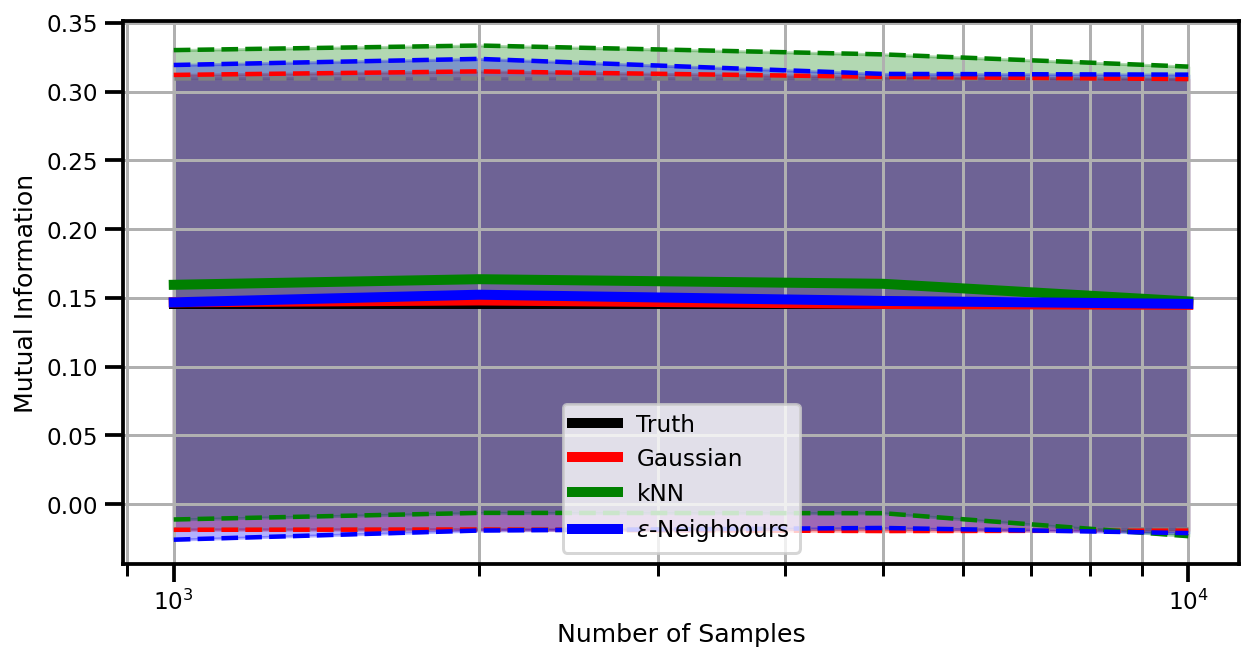

In [16]:
plot_results(results_xr, "gaussian", 1)

#### 2 Features

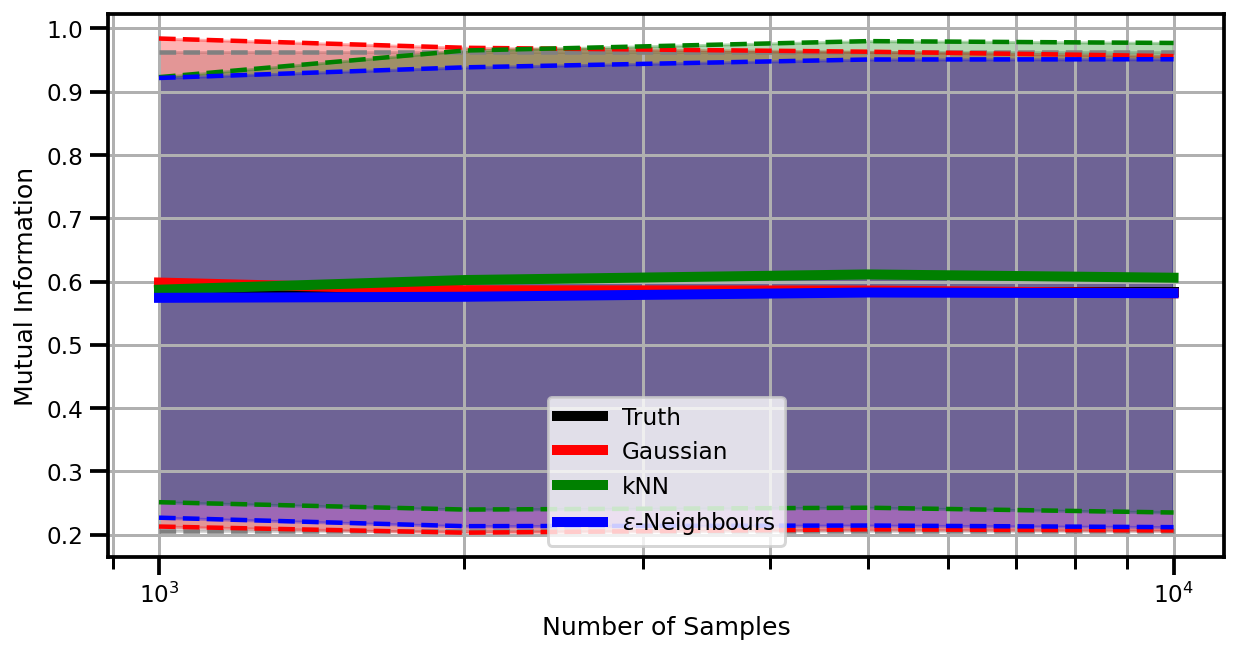

In [17]:
plot_results(results_xr, "gaussian", 2)

#### 5 Features

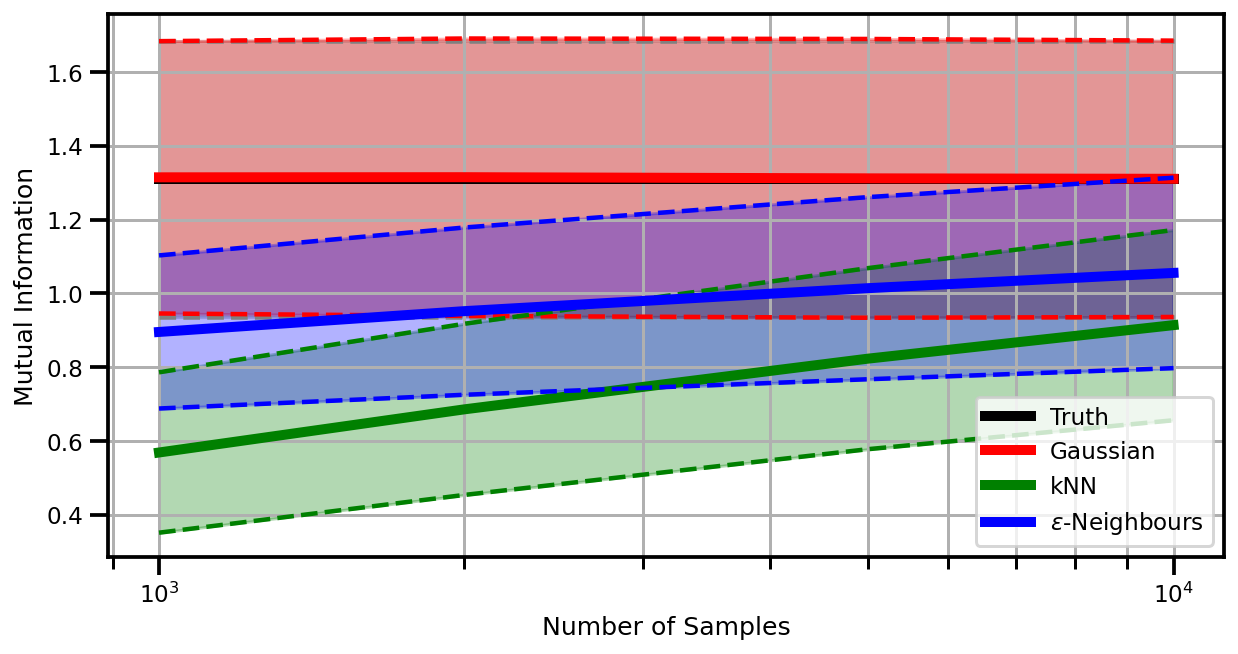

In [18]:
plot_results(results_xr, "gaussian", 5)

#### 10 Features

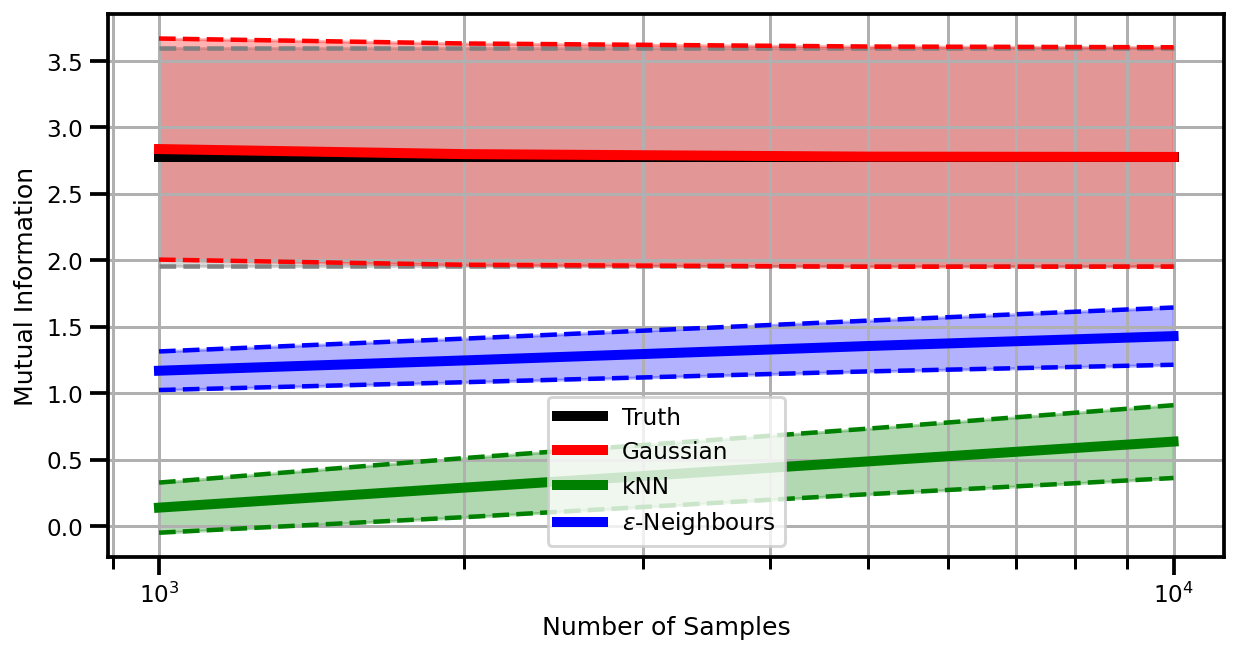

In [19]:
plot_results(results_xr, "gaussian", 10)

### Student T Distribution

#### 1 Features

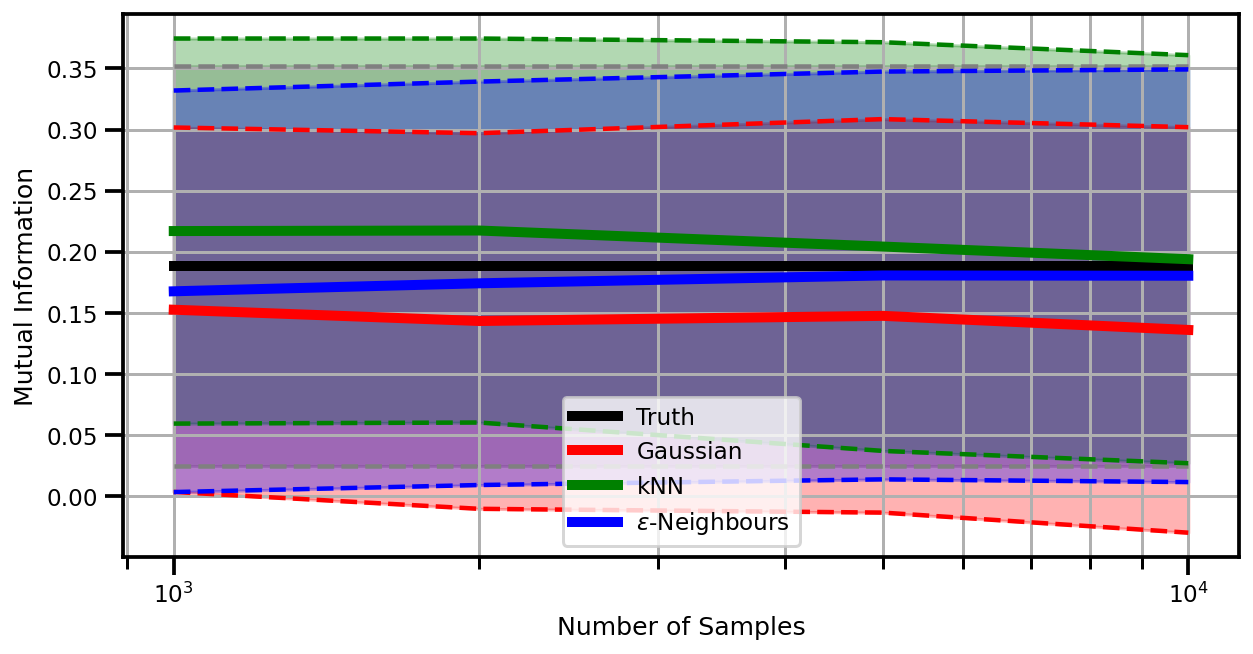

In [20]:
plot_results(results_xr, "studentt", 1)

#### 2 Features

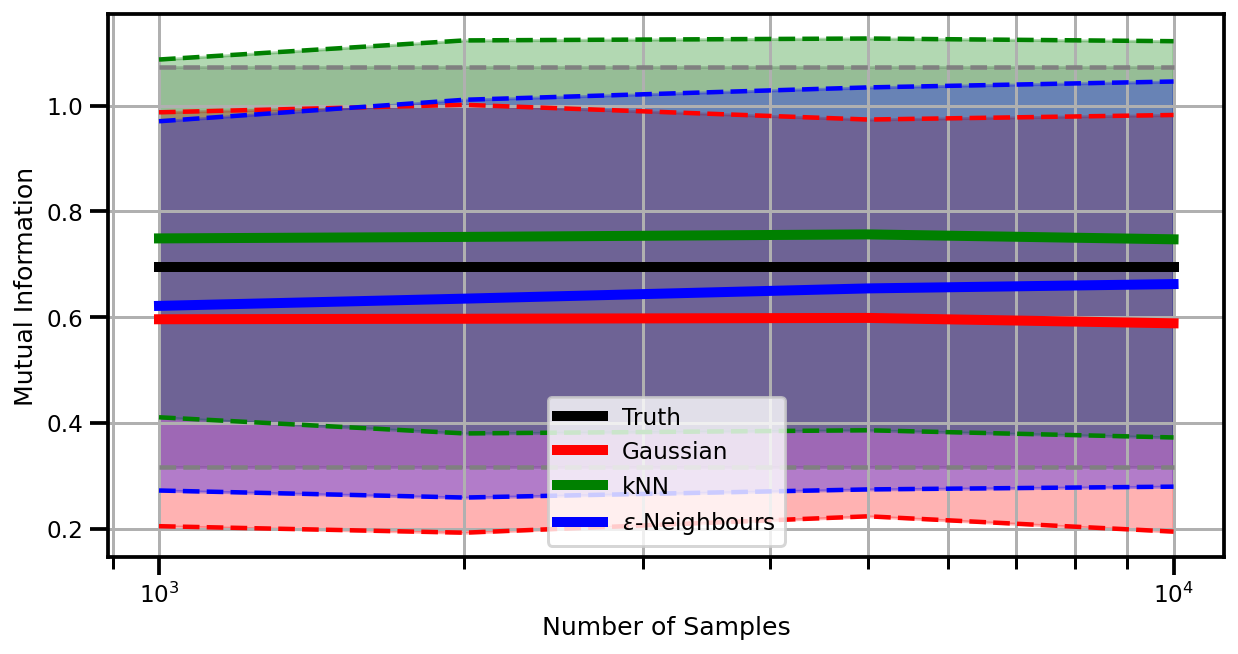

In [21]:
plot_results(results_xr, "studentt", 2)

#### 5 Features

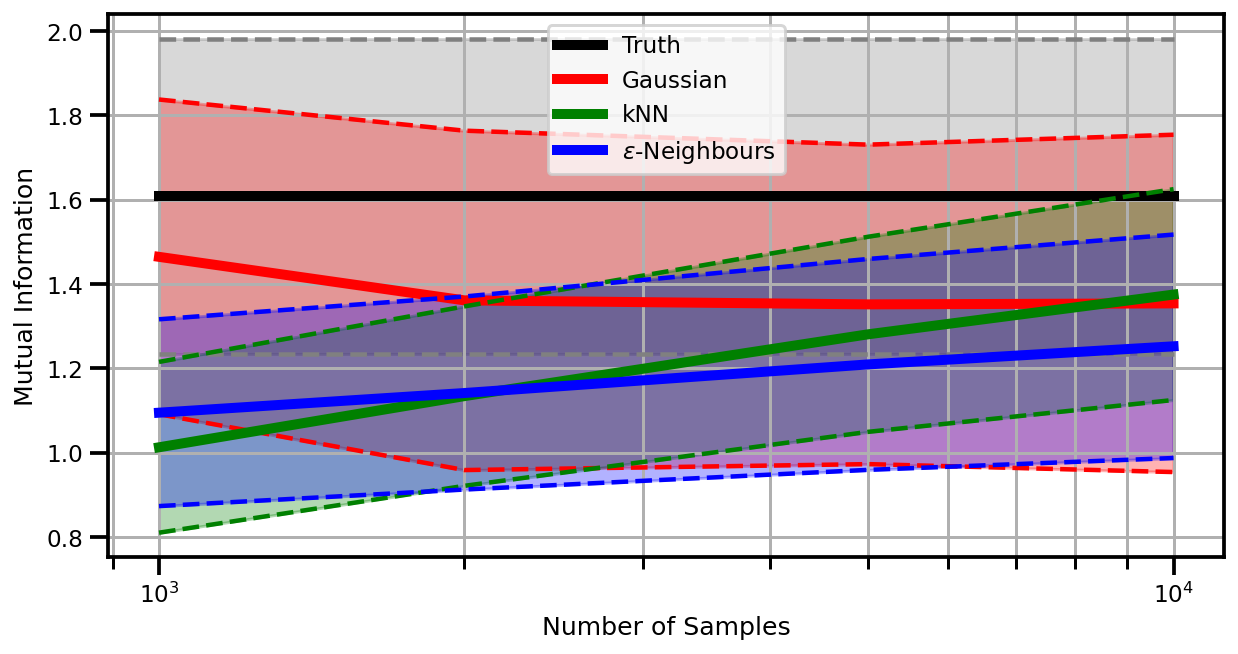

In [22]:
plot_results(results_xr, "studentt", 5)

#### 10 Features

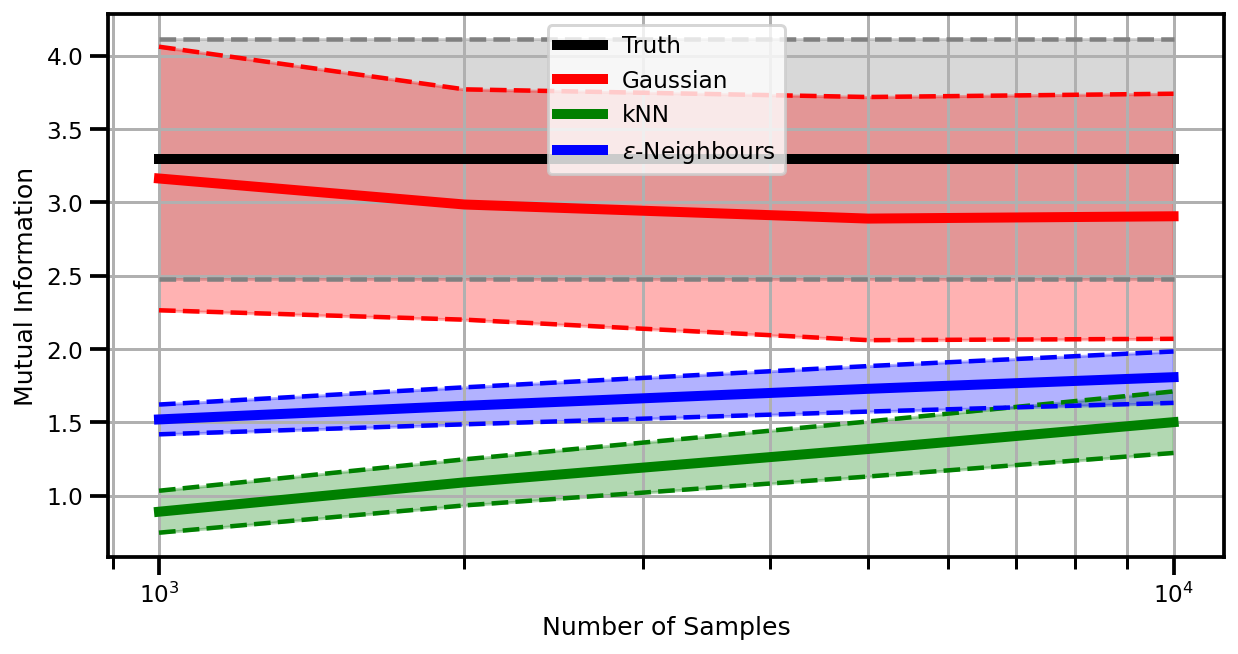

In [23]:
plot_results(results_xr, "studentt", 10)

### Cauchy

#### 1 Features

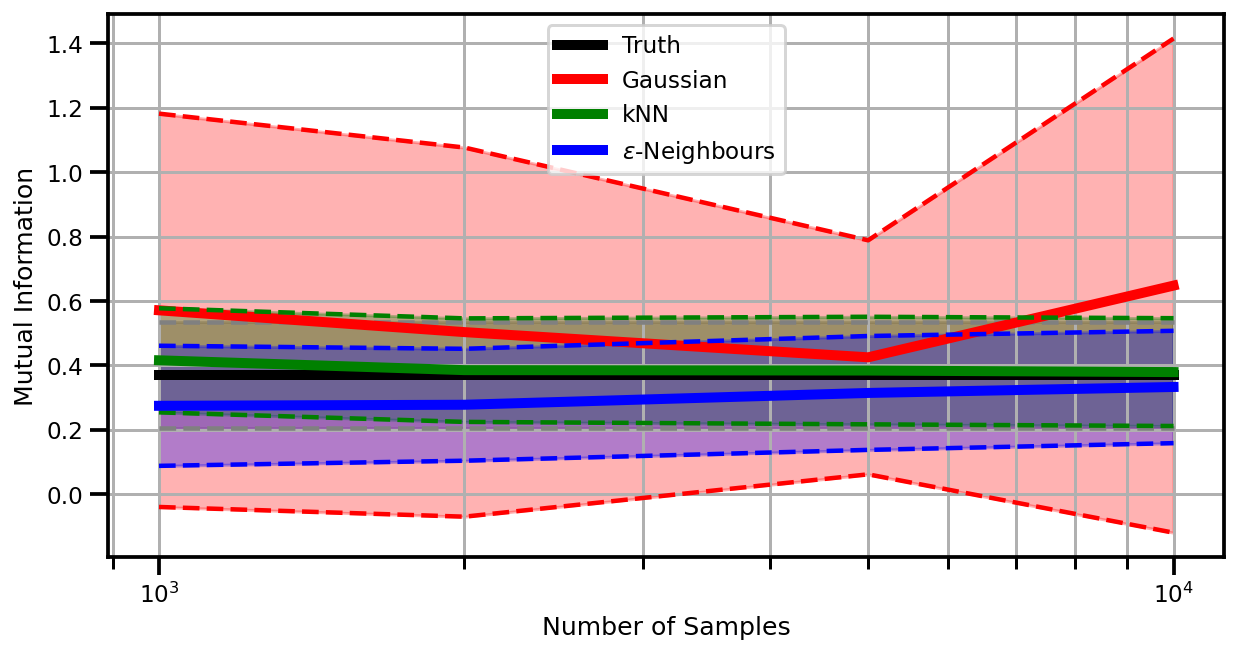

In [24]:
plot_results(results_xr, "cauchy", 1)

#### 2 Features

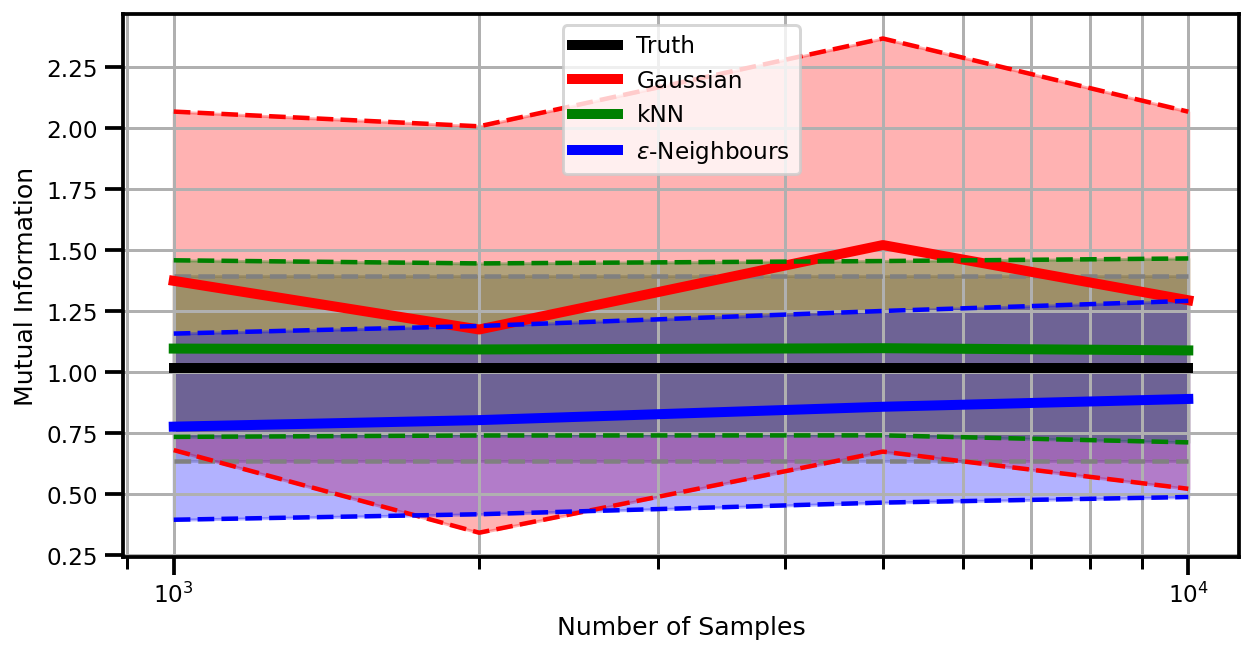

In [25]:
plot_results(results_xr, "cauchy", 2)

#### 5 Features

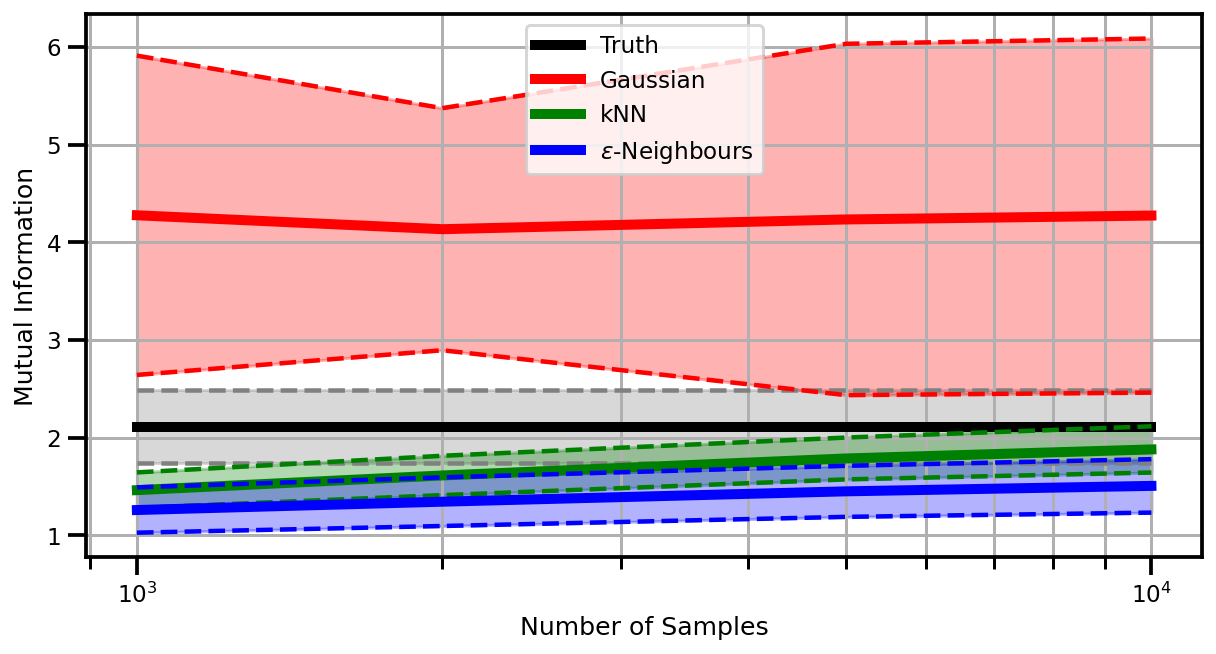

In [26]:
plot_results(results_xr, "cauchy", 5)

#### 10 Features

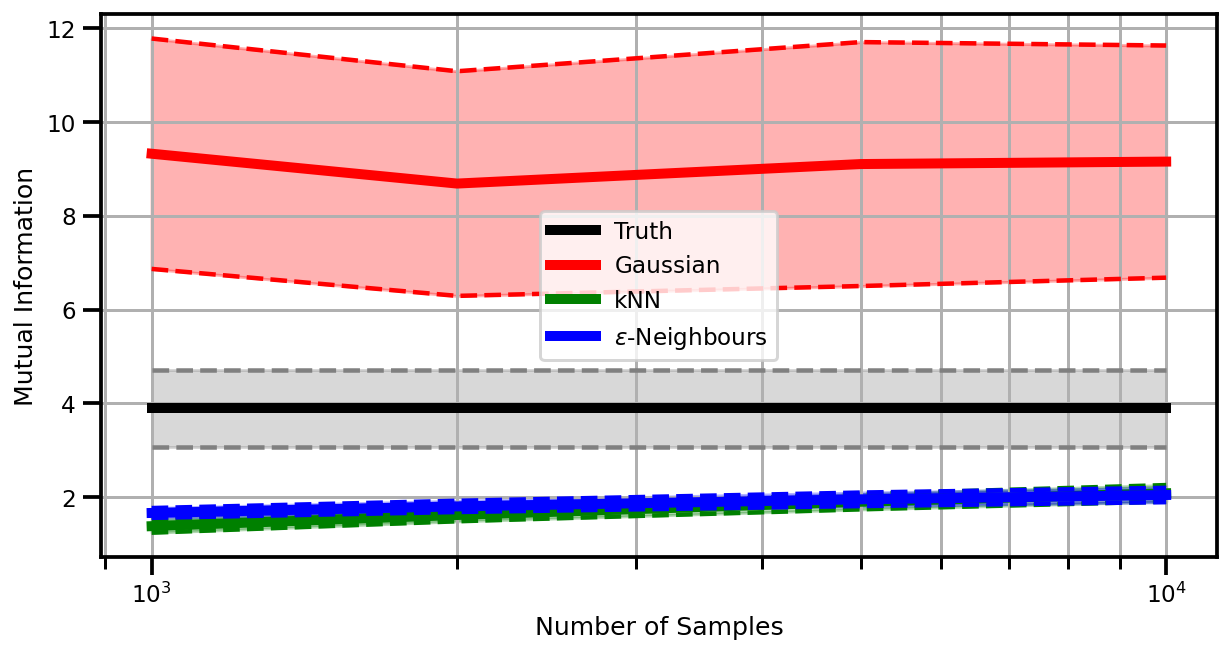

In [27]:
plot_results(results_xr, "cauchy", 10)